In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/Shareddrives/MS&E 230 Project"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Brainstorm   Miscellaneous.gdoc'   od_matrix.npy
 distance_matrix.npy		   'Project Proposal.gdoc'
 duration_matrix.npy		    sim.ipynb
 energies_2020_Nissan_Leaf_S.npy   'To do.gdoc'
 energies_2021_Dacia_Spring.npy


In [ ]:
with open('/content/drive/Shareddrives/MS&E 230 Project/distance_matrix.npy', 'rb') as f:
  dist_matrix = np.load(f)
  dist_matrix = dist_matrix[0:25, 0:25, :] # mi
with open('/content/drive/Shareddrives/MS&E 230 Project/duration_matrix.npy', 'rb') as f:
  dur_matrix = np.load(f)
  dur_matrix = dur_matrix[0:25, 0:25, :] # seconds
with open('/content/drive/Shareddrives/MS&E 230 Project/energies_2020_Nissan_Leaf_S.npy', 'rb') as f:
# with open('/content/drive/Shareddrives/MS&E 230 Project/energies_2021_Dacia_Spring.npy', 'rb') as f:
  energies_matrix = np.load(f)
  energies_matrix = energies_matrix[2:, 2:] # kWh
with open('/content/drive/Shareddrives/MS&E 230 Project/od_matrix.npy', 'rb') as f:
  od_matrix = np.load(f)
  od_matrix = od_matrix[0:25, 0:25, :] # (O, D)

print(dist_matrix.shape)
print(dur_matrix.shape)
print(energies_matrix.shape)
print(od_matrix.shape)

trip_value_matrix = dist_matrix * 0.93 + dur_matrix / 60 * 0.40 + 2.24 + 3.00 # [$] https://www.lyft.com/pricing/SFO

(25, 25, 24)
(25, 25, 24)
(25, 25)
(25, 25, 24)


In [ ]:
TIMESTEPS_PER_HOUR = 4
HOURS_IN_HORIZON = 24
T = TIMESTEPS_PER_HOUR * HOURS_IN_HORIZON
L = 25

COST_PER_MILE = 0.0746 # [$ / mi]

CHARGE_RATE = 16.8 # [kW]
BATT_CAP =  40 # 27.8 for the Dacia Spring
TARGET_CHARGE_LEVEL = 0.9

def get_hour(t):
  return int(np.floor((t / TIMESTEPS_PER_HOUR) % (24 * TIMESTEPS_PER_HOUR)))

def round_time(dur, min_val=None):
    if min_val is not None:
        return max(int(np.round(dur * TIMESTEPS_PER_HOUR)), min_val)
    else:
        return int(np.round(dur * TIMESTEPS_PER_HOUR))

In [ ]:
class Vehicle:
  def __init__(self, loc, batt_cap, know_prob):
    self.charge_level = np.random.uniform(0.5, 0.9)
    self.total_trip_utility = 0
    self.time_spent_in_queue = 0
    self.time_spent_repositioning = 0
    self.money_spent = 0
    self.curr_price = 0
    self.batt_cap = batt_cap

    self.knows = np.random.binomial(1,know_prob)==1

    # possible statuses: free, in_trip, in_charge, going_to_charge, in_queue
    self.location = loc
    if np.random.uniform() < 2:
      self.status = 'free'
      self.steps_left = 0
    else:
      self.status = 'in_trip'
      self.steps_left = np.random.choice(np.arange(1, 5))

  def done_charging(self):
    return self.charge_level > TARGET_CHARGE_LEVEL

  def charge(self, price, charge_rate):
    new_charge_level = max(1, self.charge_level + (charge_rate / TIMESTEPS_PER_HOUR) / self.batt_cap)
    energy_charged = (new_charge_level - self.charge_level) * self.batt_cap
    self.charge_level = new_charge_level
    self.money_spent += self.curr_price * energy_charged


In [ ]:
class Station:
  def __init__(self,pricing,capacity, location, charge_rate):
    self.q = []
    self.price = 0
    self.current_vehicles = [None for _ in range(capacity)]
    self.capacity = capacity
    self.location = location
    self.demand_profile = np.zeros(T)
    self.queue_profile = np.zeros(T)
    self.charge_rate = charge_rate
    self.update_price(0, pricing)

  def queue_length(self):
    return len(self.q)

  def update_price(self, t, pricing, params=None):
    hour = get_hour(t)
    if hour >= 16 and hour < 21:  # Peak
      self.price = 0.33474
    elif hour >= 9 and hour < 14:  # Super-off-peak
      self.price = 0.10320
    else:  # Off-peak
      self.price = 0.12586

    if pricing[0] == 'baseline_modified':
      if hour >= 16 and hour < 21: 
        self.price += 0.3
    if pricing[0] == 'baseline_modified2':
      if hour >= 9 and hour < 14: 
        self.price = 0.01
    if pricing[0] == "queue_length":
      self.price = self.price* (1 + pricing[1]*len(self.q)/self.capacity)
    if pricing[0] == "demand1":
      utilization = sum([1 if plug is not None else 0 for plug in self.current_vehicles]) / self.capacity
      self.price -= (2 / 3 - utilization) * self.price
    if pricing[0] == "demand2" and t >= 20:
      if np.mean(params[(t-2):t]) >= 300:
        self.price *= 5
      elif np.mean(params[(t-2):t]) <= 150:
        self.price *= 1 / 5

  def add_vehicle(self,vehicle):
    self.q.append(vehicle)

  def populate(self):

    for i in range(len(self.current_vehicles)):
      if self.current_vehicles[i] is None and self.q:
        self.current_vehicles[i] = self.q.pop(0)
        self.current_vehicles[i].status = 'in_charge'
        self.current_vehicles[i].curr_price = self.price

  def log_data(self, t):
    self.queue_profile[t] = len(self.q) # units of waiting vehicles
    self.demand_profile[t] = sum([1 if plug is not None else 0 for plug in self.current_vehicles]) * self.charge_rate # units of kW

  def serve_vehicles(self):

    for i in range(len(self.current_vehicles)):
      if self.current_vehicles[i] is not None:
        vehicle = self.current_vehicles[i]
        vehicle.charge(self.price, self.charge_rate)

        if vehicle.done_charging():
          self.current_vehicles[i].status = 'free'
          self.current_vehicles[i] = None
          


In [ ]:
class Simulation:
  def __init__(self,fleet_size,pricing,capacity,charge_level_utility=3.5,wait_cost=0,know_prob=1):
    self.pricing = pricing
    self.vehicles = []
    self.stations = []
    self.fleet_size = fleet_size
    self.charge_level_utility = charge_level_utility
    self.wait_cost = wait_cost
    self.know_prob = know_prob

    self.charge_levels = []

    for _ in range(fleet_size):
      initial_loc = np.random.choice(25) # get random loc
      self.vehicles.append(Vehicle(initial_loc, BATT_CAP, self.know_prob))

    for loc in range(L):
      self.stations.append(Station(self.pricing, capacity, loc, CHARGE_RATE))

  def max_charging_utility(self, curr_vehicle, t):
    # returns highest utility and associated station
    # (battery level) - (cost to reposition, electricity pay, queue length)

    min_cost = np.inf
    optimal_station = None
    hour = get_hour(t)

    for station in self.stations:
        cur_cost = station.price * ((TARGET_CHARGE_LEVEL - curr_vehicle.charge_level) * curr_vehicle.batt_cap)  + dist_matrix[curr_vehicle.location, station.location, hour] * COST_PER_MILE
        if curr_vehicle.knows:
          cur_cost += len(station.q) * self.wait_cost # can add coefficients and have to add distance metric for station.location
        if curr_vehicle.location != station.location:
          cur_cost += station.price * energies_matrix[curr_vehicle.location, station.location]
          charging_trip_length = round_time(dur_matrix[curr_vehicle.location, station.location, hour] / (60 * 60), min_val=1)
          charging_trip_energy = energies_matrix[curr_vehicle.location, station.location]
          if charging_trip_energy > curr_vehicle.charge_level * curr_vehicle.batt_cap:
            cur_cost = np.inf
        else:
          charging_trip_length = 0
          charging_trip_energy = 0
        if cur_cost < min_cost:
            min_cost = cur_cost
            optimal_station = station
    max_utility = 1 / curr_vehicle.charge_level * self.charge_level_utility - min_cost # or another function
    # print(1 / curr_vehicle.charge_level * CHARGE_LEVEL_UTILITY, min_cost)
    return (max_utility, optimal_station, charging_trip_length, charging_trip_energy)

  def simulate(self):
    params=None
    total_demand_profile = np.zeros(T)
    for t in range(T):
      for station in self.stations:
        station.populate()
        station.log_data(t)
        total_demand_profile += station.demand_profile
        if self.pricing[0] == "demand2":
          params = total_demand_profile
        station.update_price(t, self.pricing, params=params)
        station.serve_vehicles()
        

      random_perm = np.random.permutation(np.arange(self.fleet_size))

      for i in random_perm:
        curr_vehicle = self.vehicles[i]
        curr_status = curr_vehicle.status
        if curr_status == 'in_queue':
          curr_vehicle.time_spent_in_queue += 1
        if curr_status == 'in_charge':
          continue

        if curr_status == 'in_trip':
          curr_vehicle.steps_left -= 1
          if curr_vehicle.steps_left <= 0:
            curr_status = 'free'

        if curr_status == 'going_to_charge':
          curr_vehicle.steps_left -= 1
          if curr_vehicle.steps_left <= 0:
            curr_vehicle.status = 'in_queue'
            self.stations[curr_vehicle.location].add_vehicle(curr_vehicle) 
            # print(curr_vehicle.charge_level)

        if curr_status == 'free':
          # sample trip
          for attempts in range(100):
            hour = get_hour(t)
            destination_location = np.random.choice(25, p=od_matrix[curr_vehicle.location, :, hour] / od_matrix[curr_vehicle.location, :, hour].sum())
            trip_length = round_time(dur_matrix[curr_vehicle.location, destination_location, hour] / (60 * 60), min_val=1)
            trip_energy  = energies_matrix[curr_vehicle.location, destination_location]
            trip_dist  = dist_matrix[curr_vehicle.location, destination_location, hour]
            trip_utility = trip_value_matrix[curr_vehicle.location, destination_location, hour] - trip_dist * COST_PER_MILE
            if trip_energy < curr_vehicle.charge_level * curr_vehicle.batt_cap:
              #print(trip_utility/trip_length)
              break
            elif attempts >= 99:
              trip_utility = -np.inf
          
          if curr_vehicle.charge_level < TARGET_CHARGE_LEVEL:
            charging_utility, charging_station, charging_trip_length, charging_trip_energy = self.max_charging_utility(curr_vehicle, t)
          else:
            charging_utility = -np.inf
            charging_station = None
            charging_trip_length = 0
            charging_trip_energy = 0
          # print(trip_utility,charging_utility)
          if trip_utility < charging_utility: 
            self.charge_levels.append(curr_vehicle.charge_level)
            curr_vehicle.location = charging_station.location
            curr_vehicle.charge_level -= charging_trip_energy / curr_vehicle.batt_cap
            curr_vehicle.status = 'going_to_charge'
            curr_vehicle.steps_left = charging_trip_length
            curr_vehicle.time_spent_repositioning += charging_trip_length
          else:
            curr_vehicle.location = destination_location
            curr_vehicle.charge_level -= trip_energy / curr_vehicle.batt_cap
            curr_vehicle.status = 'in_trip'
            curr_vehicle.steps_left = trip_length
            curr_vehicle.total_trip_utility += trip_utility

In [ ]:
class Experiment:
  def __init__(self, sim, iters=10):
    self.sim = sim
    self.iters = iters
    
    self.total_utility_list = []
    self.total_timestep_queue_list = []
    self.total_money_spent_list = []
    self.total_repositioning_list = []
    self.max_demand_list = []
    self.plugs_used_list = np.zeros(iters)

    self.total_demand_profile_all = np.zeros((iters,T))

  def run(self):
    for i in range(iters):
      self.sim.simulate()
      total_demand_profile = np.zeros(T)
      for station in self.sim.stations:
        total_demand_profile += station.demand_profile
        self.plugs_used_list[i] += max(station.demand_profile) / station.charge_rate
      self.total_demand_profile_all[i] = total_demand_profile
      self.max_demand_list.append(max(total_demand_profile))
      vehicles_total_trip_utility = []
      vehicles_time_spent_in_queue = []
      vehicles_money_spent = []
      vehicles_repositioning = []
      for vehicle in self.sim.vehicles:
        vehicles_total_trip_utility.append(vehicle.total_trip_utility)
        vehicles_time_spent_in_queue.append(vehicle.time_spent_in_queue)
        vehicles_money_spent.append(vehicle.money_spent)
        vehicles_repositioning.append(vehicle.time_spent_repositioning)
      self.total_utility_list.append(sum(vehicles_total_trip_utility))
      self.total_timestep_queue_list.append(sum(vehicles_time_spent_in_queue))
      self.total_money_spent_list.append(sum(vehicles_money_spent))
      self.total_repositioning_list.append(sum(vehicles_repositioning))
    print('Total Utility: {}'.format(np.mean(self.total_utility_list)))
    print('Total Time Spent in Queue: {}'.format(np.mean(self.total_timestep_queue_list)))
    print('Maximum Demand: {}'.format(np.mean(self.max_demand_list)))
    print('Total Money Spent: {}'.format(np.mean(self.total_money_spent_list)))
    print('Total Time Spent Repositioning: {}'.format(np.mean(self.total_repositioning_list)))
    print('Plugs Used: {}'.format(np.mean(self.plugs_used_list)))

def plot_total_demand_profile_all(total_demand_profile_all):
  fig, ax = plt.subplots(figsize=(9,6), dpi=200)
  plt.plot(np.arange(0, 24, 1 / TIMESTEPS_PER_HOUR),np.mean(total_demand_profile_all,axis=0))
  plt.xticks(fontsize=15)
  formatter = FuncFormatter(lambda h, x: time.strftime('%H:%M', time.gmtime(h * 3600)))
  ax.xaxis.set_ticks(np.arange(0, 24, 4))
  ax.xaxis.set_major_formatter(formatter)
  plt.yticks(fontsize=15)
  plt.xlabel('Time', fontsize=15)
  plt.ylabel('Total Demand (kW)', fontsize=15)


In [ ]:
# BASELINE
exp_baseline = Experiment(Simulation(1000, ("queue_length", 0), 3, wait_cost=0, know_prob=0))
exp_baseline.run()

Total Utility: 5523077.205116321
Total Time Spent in Queue: 5922.5
Maximum Demand: 599.7600000000001
Total Money Spent: 47166.7175901729
Total Time Spent Repositioning: 17204.2
Plugs Used: 70.4


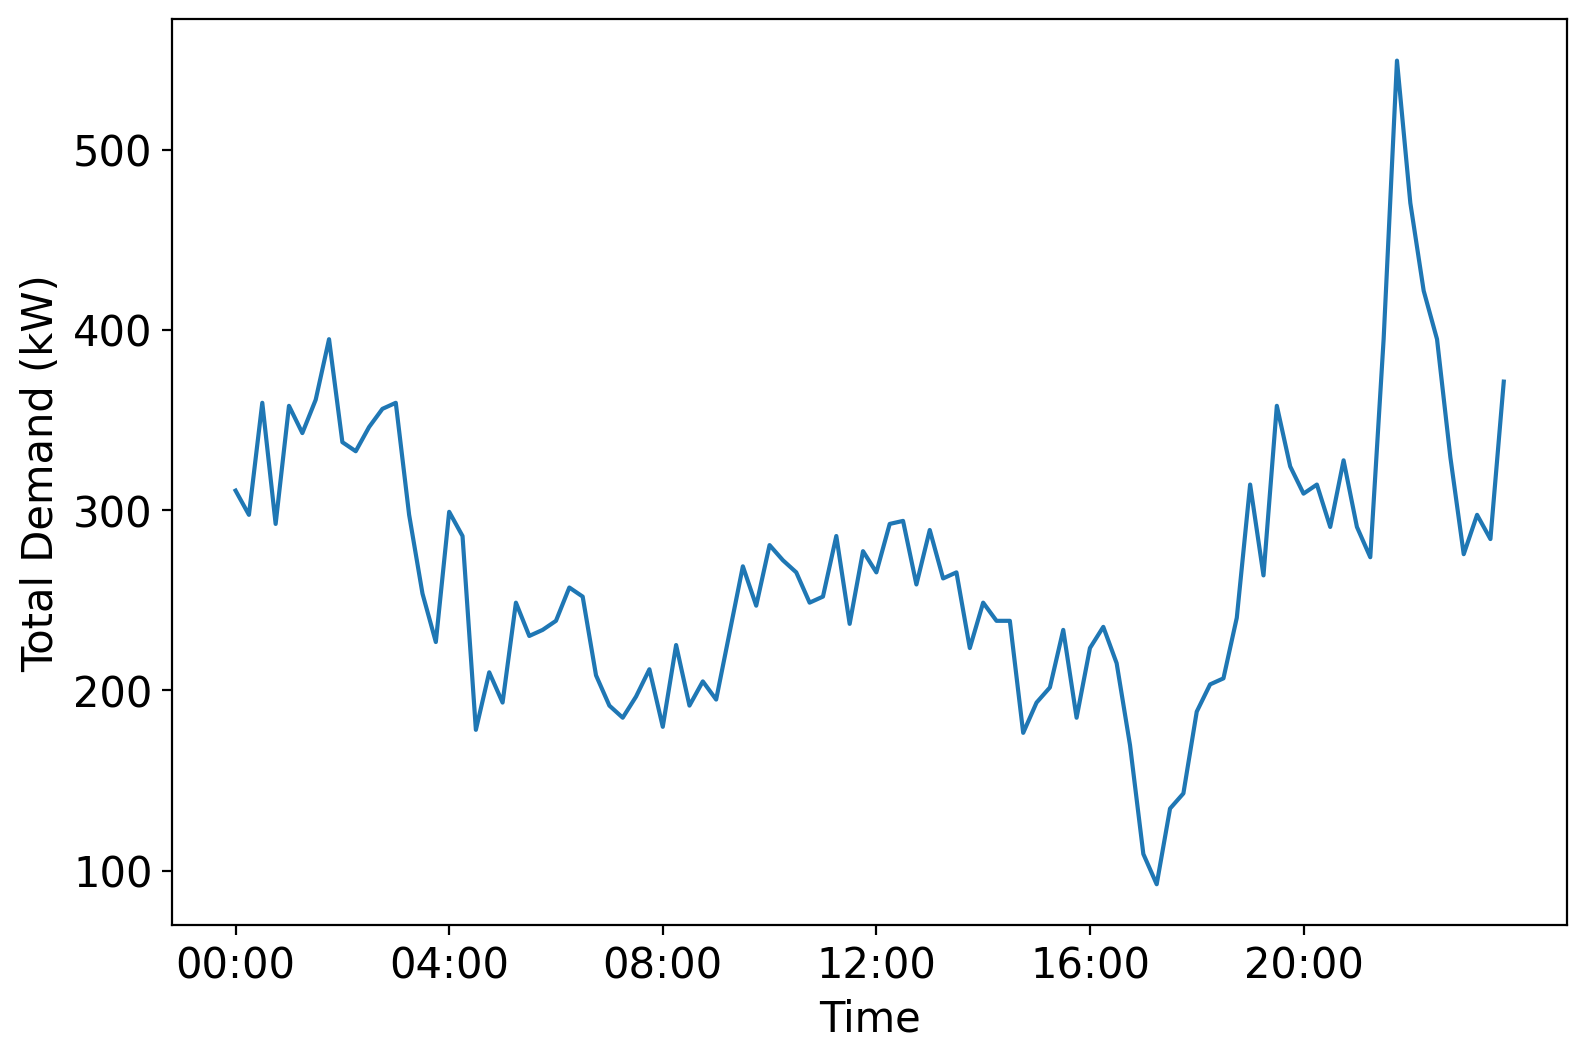

In [ ]:
plot_total_demand_profile_all(exp_baseline.total_demand_profile_all)

In [ ]:
# BASELINE MODIFIED
exp_baseline_mod = Experiment(Simulation(1000, ("baseline_modified", 0),3,wait_cost=0,know_prob=0))
exp_baseline_mod.run()

Total Utility: 5525471.054542109
Total Time Spent in Queue: 6268.9
Maximum Demand: 776.16
Total Money Spent: 60101.640799068184
Total Time Spent Repositioning: 17089.6
Plugs Used: 70.0


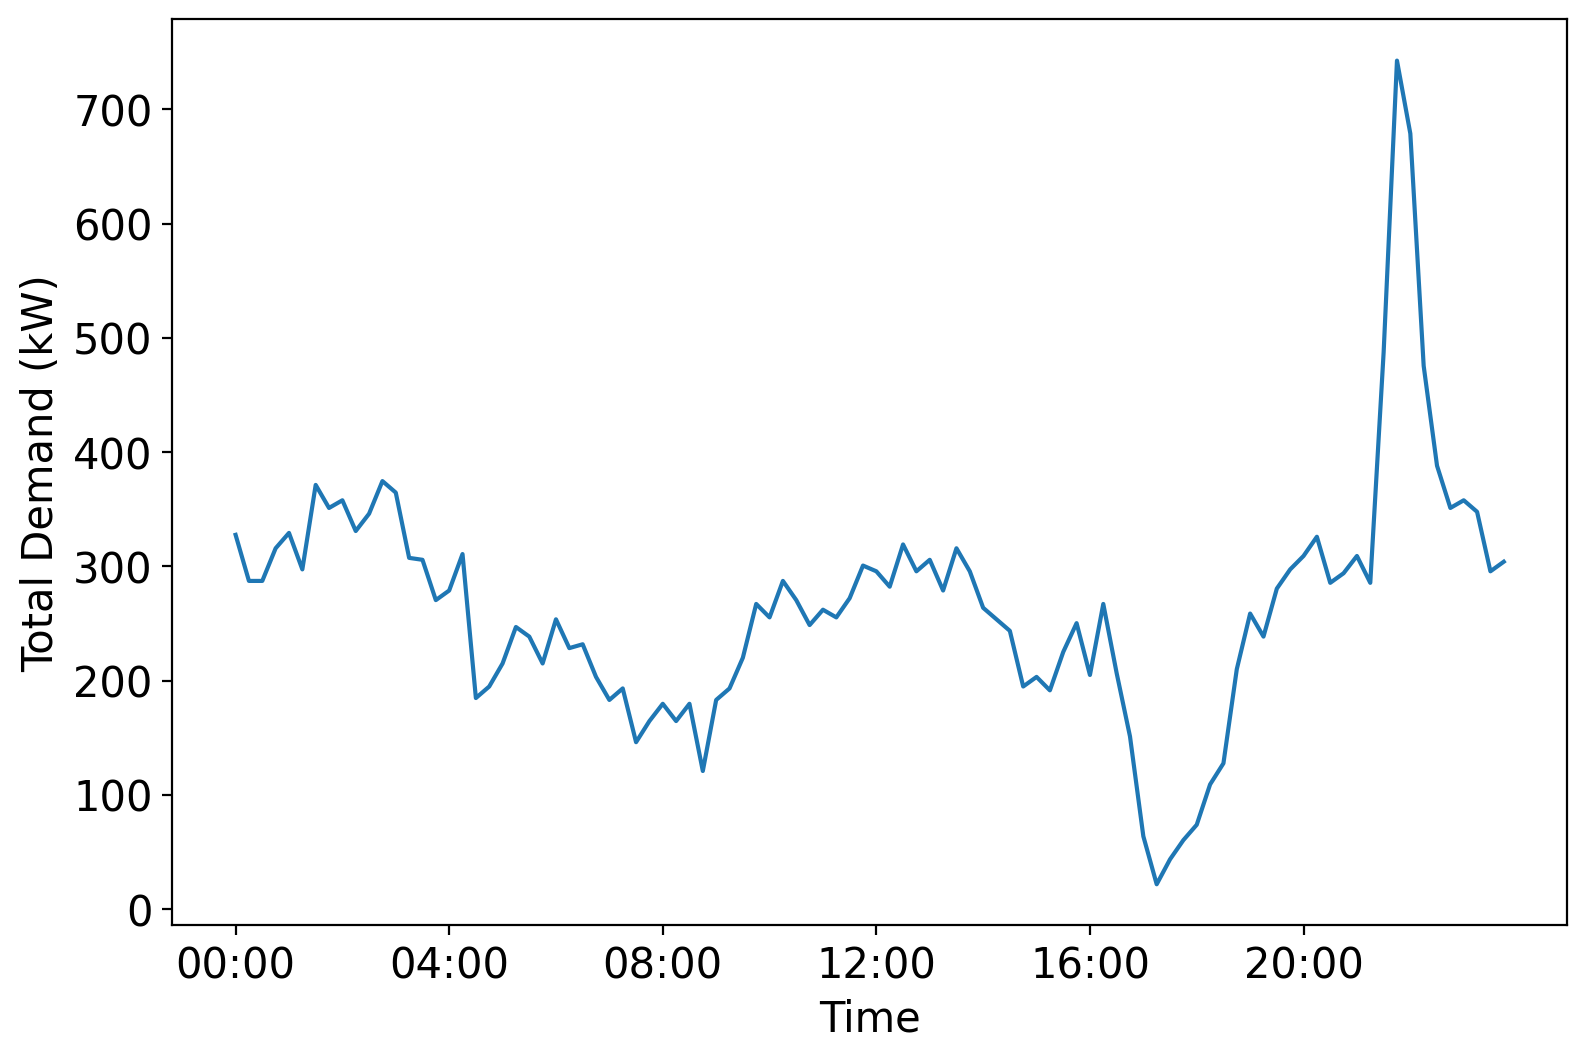

In [ ]:
plot_total_demand_profile_all(exp_baseline_mod.total_demand_profile_all)

Total Utility: 5509045.208355587
Total Time Spent in Queue: 7312.0
Maximum Demand: 608.1600000000001
Total Money Spent: 40851.65730168651
Total Time Spent Repositioning: 17271.0
Plugs Used: 70.3


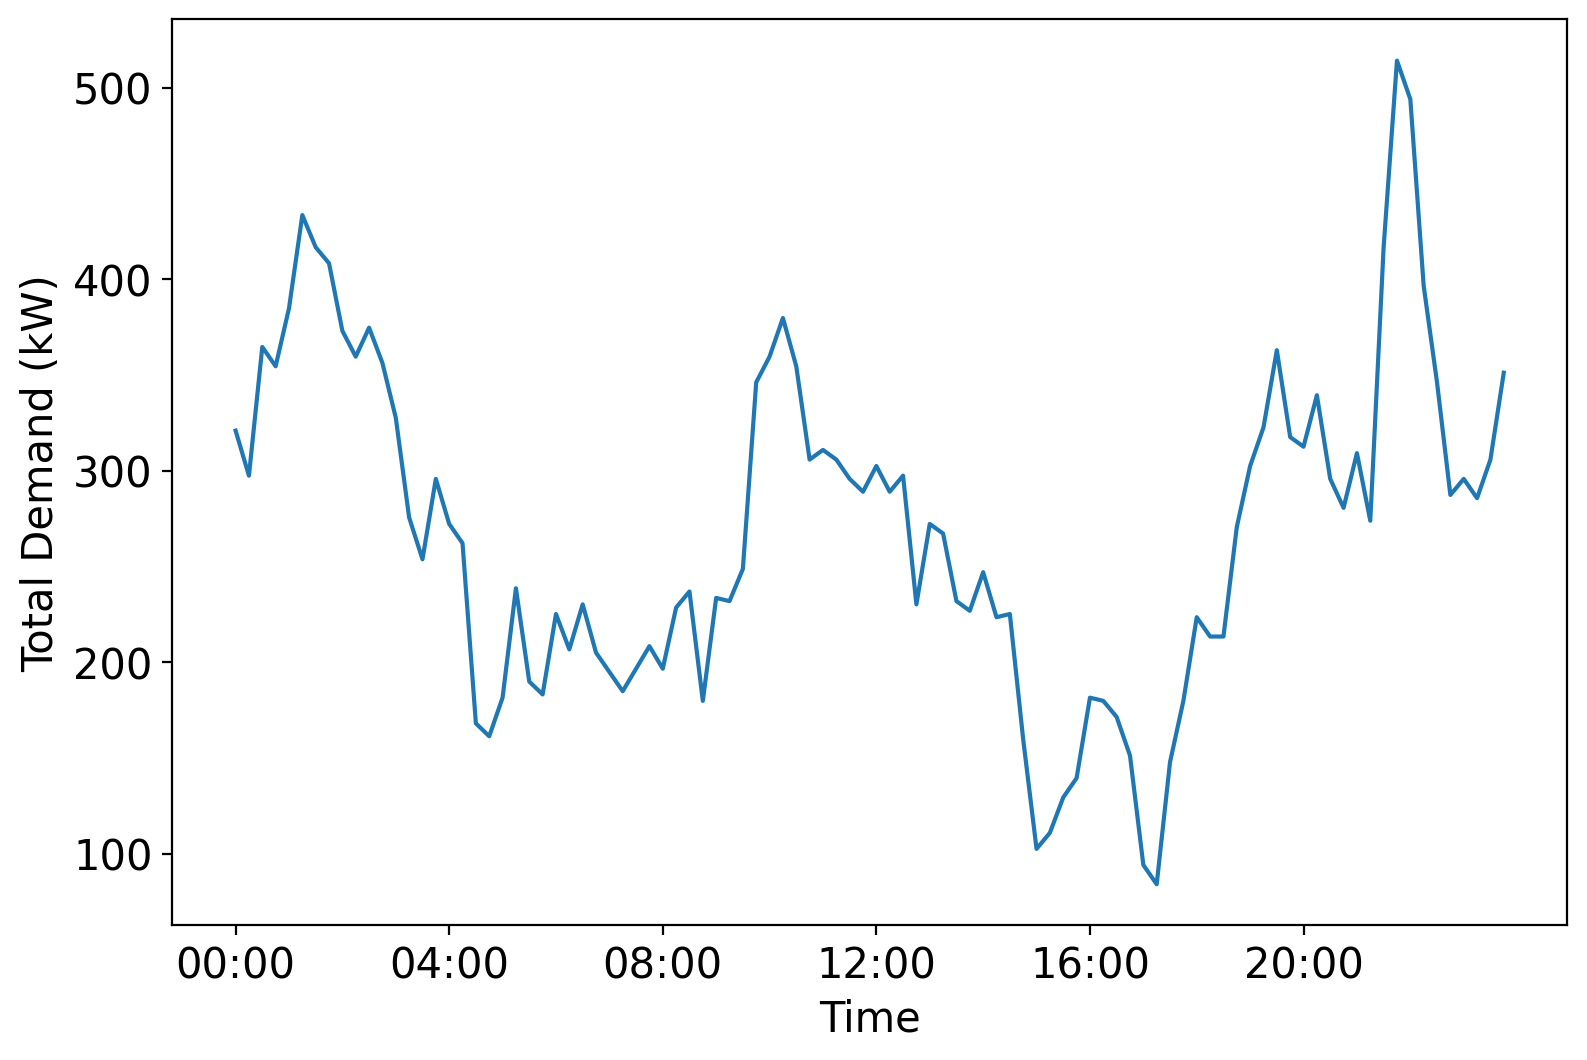

In [ ]:
# BASELINE MODIFIED 2
exp_baseline_mod2 = Experiment(Simulation(1000, ("baseline_modified2", 0),3,wait_cost=0,know_prob=0))
exp_baseline_mod2.run()
plot_total_demand_profile_all(exp_baseline_mod2.total_demand_profile_all)

In [ ]:
# VARY PRICING AGGRESSIVENESS

pricing_coefs = np.arange(0,0.51,0.05)

iters = 10
fleet_size = 1000
total_utility_list = []
total_timestep_queue_list = []
total_money_spent_list = []
max_demand_list = []
total_demand_profile_all = np.zeros((iters,len(pricing_coefs),T))

for i,coef in enumerate(pricing_coefs):
  util_list = []
  q_list = []
  money_list = []
  demand_list = []
  for it in range(iters):
    pricing = ("queue_length", coef)
    sim = Simulation(fleet_size, pricing,3,wait_cost=0,know_prob=0)
    sim.simulate()
    total_demand_profile = np.zeros(T)
    for station in sim.stations:
      total_demand_profile += station.demand_profile
    total_demand_profile_all[it,i] += total_demand_profile
    demand_list.append(max(total_demand_profile))
    vehicles_total_trip_utility = []
    vehicles_time_spent_in_queue = []
    vehicles_money_spent = []
    for vehicle in sim.vehicles:
      vehicles_total_trip_utility.append(vehicle.total_trip_utility)
      vehicles_time_spent_in_queue.append(vehicle.time_spent_in_queue)
      vehicles_money_spent.append(vehicle.money_spent)
    util_list.append(sum(vehicles_total_trip_utility))
    q_list.append(sum(vehicles_time_spent_in_queue))
    money_list.append(sum(vehicles_money_spent))
  max_demand_list.append(np.mean(demand_list))
  total_utility_list.append(np.mean(util_list))
  total_timestep_queue_list.append(np.mean(q_list))
  total_money_spent_list.append(np.mean(money_list))

Text(0, 0.5, 'Maximum Charging Demand (kW)')

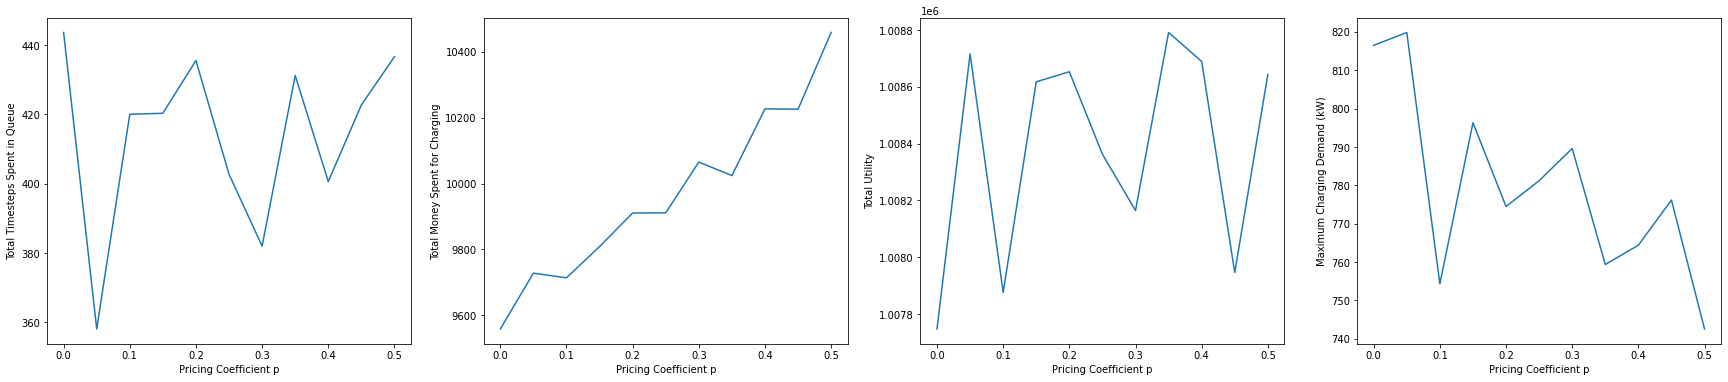

In [ ]:
_, ax = plt.subplots(nrows=1,ncols=4,figsize=(30,6))

ax[0].plot(pricing_coefs,total_timestep_queue_list)
ax[0].set_xlabel("Pricing Coefficient p")
ax[0].set_ylabel("Total Timesteps Spent in Queue")
ax[1].plot(pricing_coefs,total_money_spent_list)
ax[1].set_xlabel("Pricing Coefficient p")
ax[1].set_ylabel("Total Money Spent for Charging")
ax[2].plot(pricing_coefs,total_utility_list)
ax[2].set_xlabel("Pricing Coefficient p")
ax[2].set_ylabel("Total Utility")
ax[3].plot(pricing_coefs,max_demand_list)
ax[3].set_xlabel("Pricing Coefficient p")
ax[3].set_ylabel("Maximum Charging Demand (kW)")

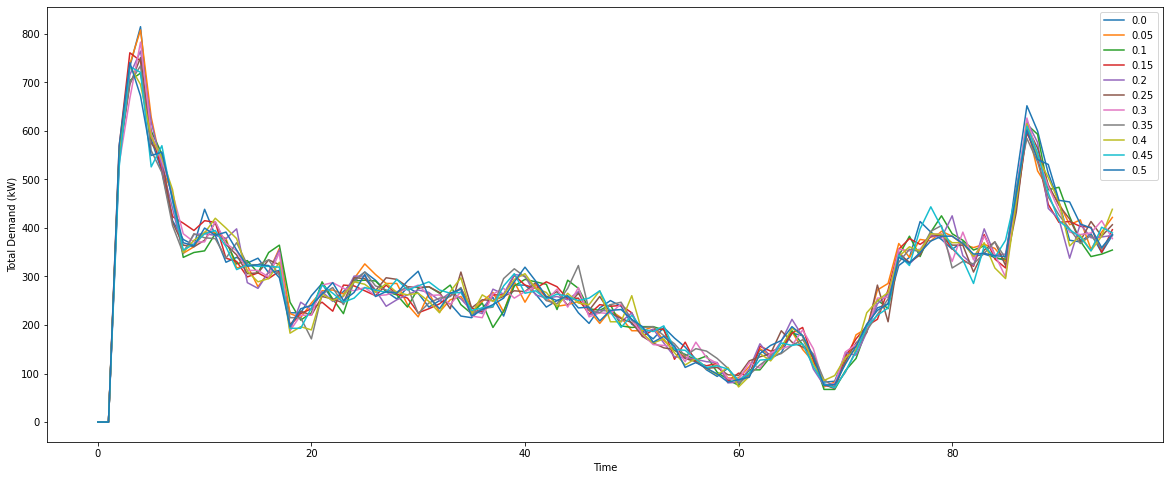

In [ ]:
_, ax = plt.subplots(figsize=(20,8))
for i in range(len(total_demand_profile_all[1])):
  ax.plot(list(range(T)),np.mean(total_demand_profile_all,axis=0)[i],label=str(round(pricing_coefs[i],2)))
plt.xlabel('Time')
plt.ylabel('Total Demand (kW)')
plt.legend()

In [ ]:
# VARY WAIT_COSTS

wait_costs = [0,5,10,15,20,25]

iters = 10
fleet_size = 1000
total_utility_list = []
total_timestep_queue_list = []
total_money_spent_list = []
max_demand_list = []
total_demand_profile_all = np.zeros((iters,len(wait_costs),T))

for i,wait_cost in enumerate(wait_costs):
  util_list = []
  q_list = []
  money_list = []
  demand_list = []
  for it in range(iters):
    pricing = ("queue_length", 0)
    sim = Simulation(fleet_size, pricing,3,wait_cost=wait_cost,know_prob=1)
    sim.simulate()
    total_demand_profile = np.zeros(T)
    for station in sim.stations:
      total_demand_profile += station.demand_profile
    total_demand_profile_all[it,i] += total_demand_profile
    demand_list.append(max(total_demand_profile))
    vehicles_total_trip_utility = []
    vehicles_time_spent_in_queue = []
    vehicles_money_spent = []
    for vehicle in sim.vehicles:
      vehicles_total_trip_utility.append(vehicle.total_trip_utility)
      vehicles_time_spent_in_queue.append(vehicle.time_spent_in_queue)
      vehicles_money_spent.append(vehicle.money_spent)
    util_list.append(sum(vehicles_total_trip_utility))
    q_list.append(sum(vehicles_time_spent_in_queue))
    money_list.append(sum(vehicles_money_spent))
  max_demand_list.append(np.mean(demand_list))
  total_utility_list.append(np.mean(util_list))
  total_timestep_queue_list.append(np.mean(q_list))
  total_money_spent_list.append(np.mean(money_list))

Text(0, 0.5, 'Maximum Charging Demand (kW)')

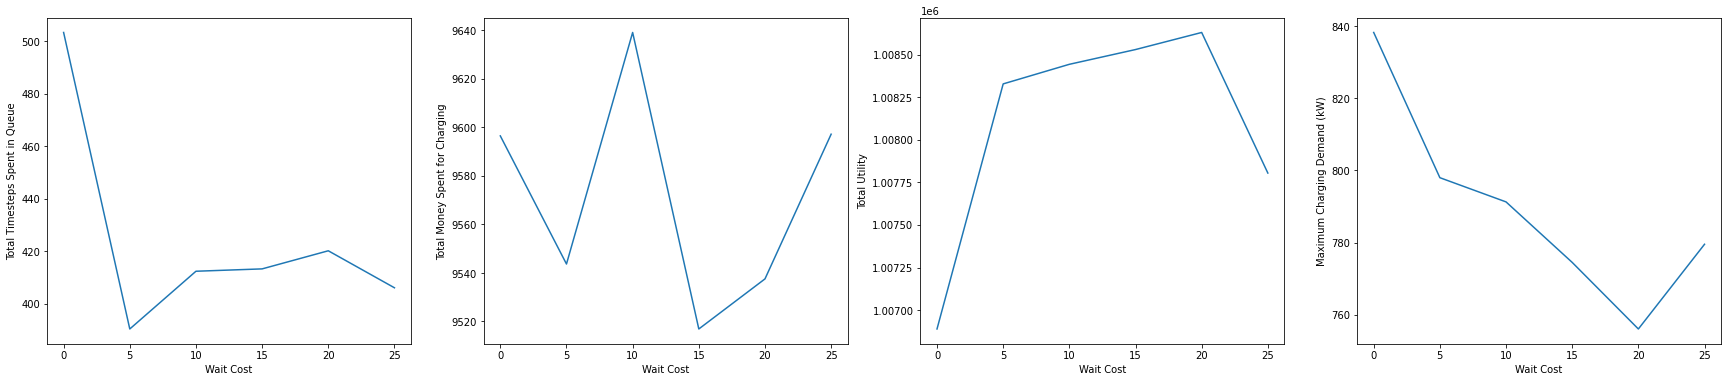

In [ ]:
_, ax = plt.subplots(nrows=1,ncols=4,figsize=(30,6))

ax[0].plot(wait_costs,total_timestep_queue_list)
ax[0].set_xlabel("Wait Cost")
ax[0].set_ylabel("Total Timesteps Spent in Queue")
ax[1].plot(wait_costs,total_money_spent_list)
ax[1].set_xlabel("Wait Cost")
ax[1].set_ylabel("Total Money Spent for Charging")
ax[2].plot(wait_costs,total_utility_list)
ax[2].set_xlabel("Wait Cost")
ax[2].set_ylabel("Total Utility")
ax[3].plot(wait_costs,max_demand_list)
ax[3].set_xlabel("Wait Cost")
ax[3].set_ylabel("Maximum Charging Demand (kW)")

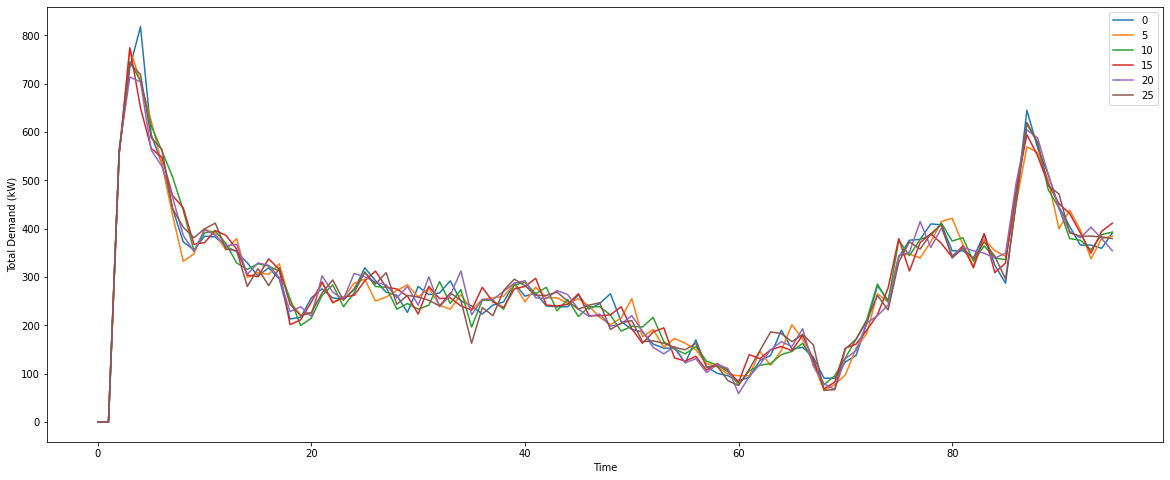

In [ ]:
_, ax = plt.subplots(figsize=(20,8))
for i in range(len(total_demand_profile_all[1])):
  ax.plot(list(range(T)),np.mean(total_demand_profile_all,axis=0)[i],label=str(round(wait_costs[i],2)))
plt.xlabel('Time')
plt.ylabel('Total Demand (kW)')
plt.legend()

In [ ]:
# VARY KNOW_PROB

know_probs = [0,0.2,0.4,0.6,0.8,1]

iters = 10
fleet_size = 1000
wait_cost = 5 # ?????????????
total_utility_list = []
total_timestep_queue_list = []
total_money_spent_list = []
max_demand_list = []
total_demand_profile_all = np.zeros((iters,len(know_probs),T))

for i,know_prob in enumerate(know_probs):
  util_list = []
  q_list = []
  money_list = []
  demand_list = []
  for it in range(iters):
    pricing = ("queue_length", 0)
    sim = Simulation(fleet_size, pricing,3,wait_cost=wait_cost,know_prob=know_prob)
    sim.simulate()
    total_demand_profile = np.zeros(T)
    for station in sim.stations:
      total_demand_profile += station.demand_profile
    total_demand_profile_all[it,i] += total_demand_profile
    demand_list.append(max(total_demand_profile))
    vehicles_total_trip_utility = []
    vehicles_time_spent_in_queue = []
    vehicles_money_spent = []
    for vehicle in sim.vehicles:
      vehicles_total_trip_utility.append(vehicle.total_trip_utility)
      vehicles_time_spent_in_queue.append(vehicle.time_spent_in_queue)
      vehicles_money_spent.append(vehicle.money_spent)
    util_list.append(sum(vehicles_total_trip_utility))
    q_list.append(sum(vehicles_time_spent_in_queue))
    money_list.append(sum(vehicles_money_spent))
  max_demand_list.append(np.mean(demand_list))
  total_utility_list.append(np.mean(util_list))
  total_timestep_queue_list.append(np.mean(q_list))
  total_money_spent_list.append(np.mean(money_list))

Text(0, 0.5, 'Maximum Charging Demand (kW)')

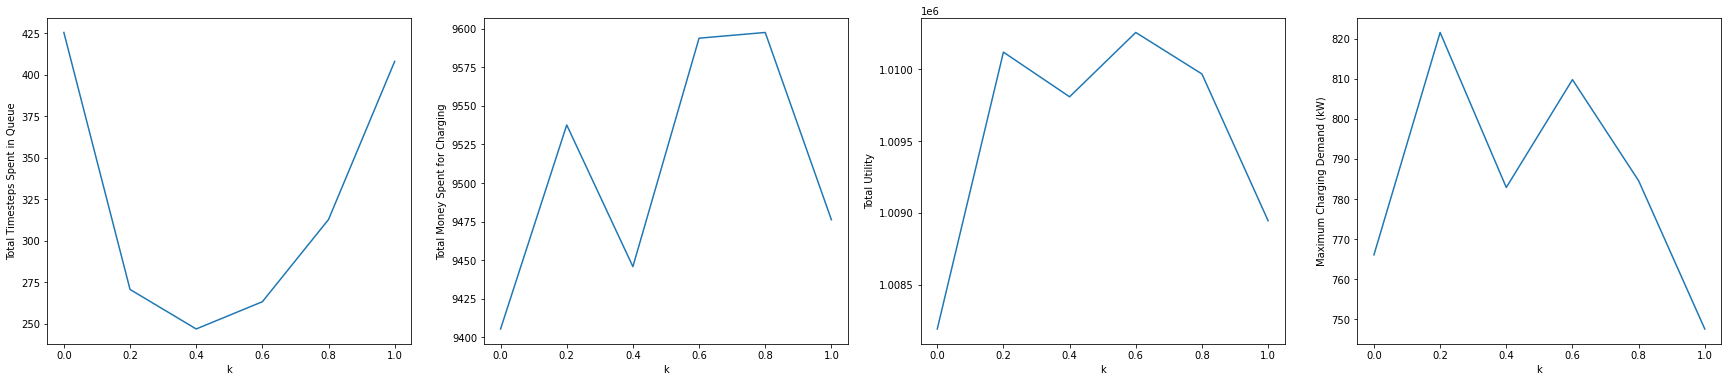

In [ ]:
_, ax = plt.subplots(nrows=1,ncols=4,figsize=(30,6))

ax[0].plot(know_probs,total_timestep_queue_list)
ax[0].set_xlabel("k")
ax[0].set_ylabel("Total Timesteps Spent in Queue")
ax[1].plot(know_probs,total_money_spent_list)
ax[1].set_xlabel("k")
ax[1].set_ylabel("Total Money Spent for Charging")
ax[2].plot(know_probs,total_utility_list)
ax[2].set_xlabel("k")
ax[2].set_ylabel("Total Utility")
ax[3].plot(know_probs,max_demand_list)
ax[3].set_xlabel("k")
ax[3].set_ylabel("Maximum Charging Demand (kW)")

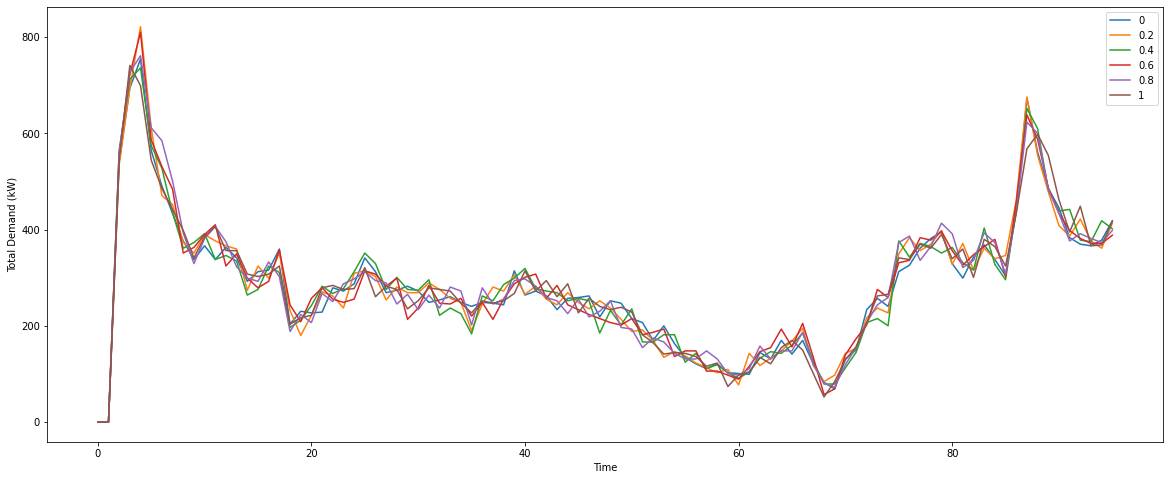

In [ ]:
_, ax = plt.subplots(figsize=(20,8))
for i in range(len(total_demand_profile_all[1])):
  ax.plot(list(range(T)),np.mean(total_demand_profile_all,axis=0)[i],label=str(round(know_probs[i],2)))
plt.xlabel('Time')
plt.ylabel('Total Demand (kW)')
plt.legend()

In [ ]:
# VARY FLEET SIZE AND CAPACITY

fleet_sizes = [1000,2000,3000,4000,5000]
capacities = [3,6,9,12,15]

iters = 10
total_utility_list = []
total_timestep_queue_list = []
total_money_spent_list = []
max_demand_list = []
total_demand_profile_all = np.zeros((iters,len(fleet_sizes),T))

for i,(fleet_size, capacity) in enumerate(zip(fleet_sizes,capacities)):
  util_list = []
  q_list = []
  money_list = []
  demand_list = []
  for it in range(iters):
    pricing = ("queue_length", 0)
    sim = Simulation(fleet_size, pricing,capacity,wait_cost=0,know_prob=0)
    sim.simulate()
    total_demand_profile = np.zeros(T)
    for station in sim.stations:
      total_demand_profile += station.demand_profile
    total_demand_profile_all[it,i] += total_demand_profile
    demand_list.append(max(total_demand_profile))
    vehicles_total_trip_utility = []
    vehicles_time_spent_in_queue = []
    vehicles_money_spent = []
    for vehicle in sim.vehicles:
      vehicles_total_trip_utility.append(vehicle.total_trip_utility)
      vehicles_time_spent_in_queue.append(vehicle.time_spent_in_queue)
      vehicles_money_spent.append(vehicle.money_spent)
    util_list.append(sum(vehicles_total_trip_utility))
    q_list.append(sum(vehicles_time_spent_in_queue))
    money_list.append(sum(vehicles_money_spent))
  max_demand_list.append(np.mean(demand_list))
  total_utility_list.append(np.mean(util_list))
  total_timestep_queue_list.append(np.mean(q_list))
  total_money_spent_list.append(np.mean(money_list))

Text(0, 0.5, 'Maximum Charging Demand (kW)')

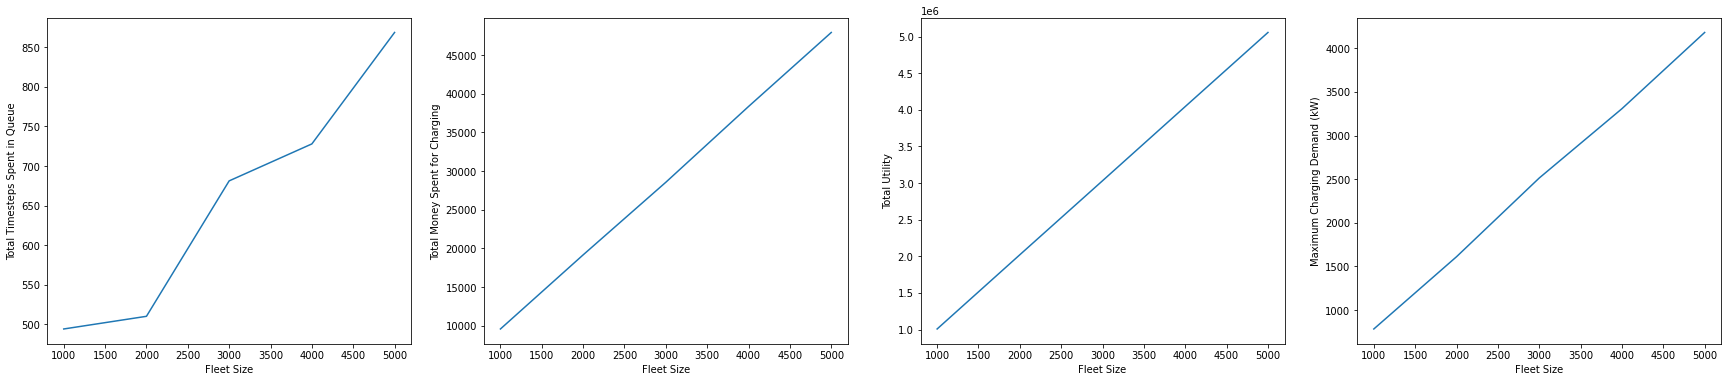

In [ ]:
_, ax = plt.subplots(nrows=1,ncols=4,figsize=(30,6))

ax[0].plot(fleet_sizes,total_timestep_queue_list)
ax[0].set_xlabel("Fleet Size")
ax[0].set_ylabel("Total Timesteps Spent in Queue")
ax[1].plot(fleet_sizes,total_money_spent_list)
ax[1].set_xlabel("Fleet Size")
ax[1].set_ylabel("Total Money Spent for Charging")
ax[2].plot(fleet_sizes,total_utility_list)
ax[2].set_xlabel("Fleet Size")
ax[2].set_ylabel("Total Utility")
ax[3].plot(fleet_sizes,max_demand_list)
ax[3].set_xlabel("Fleet Size")
ax[3].set_ylabel("Maximum Charging Demand (kW)")

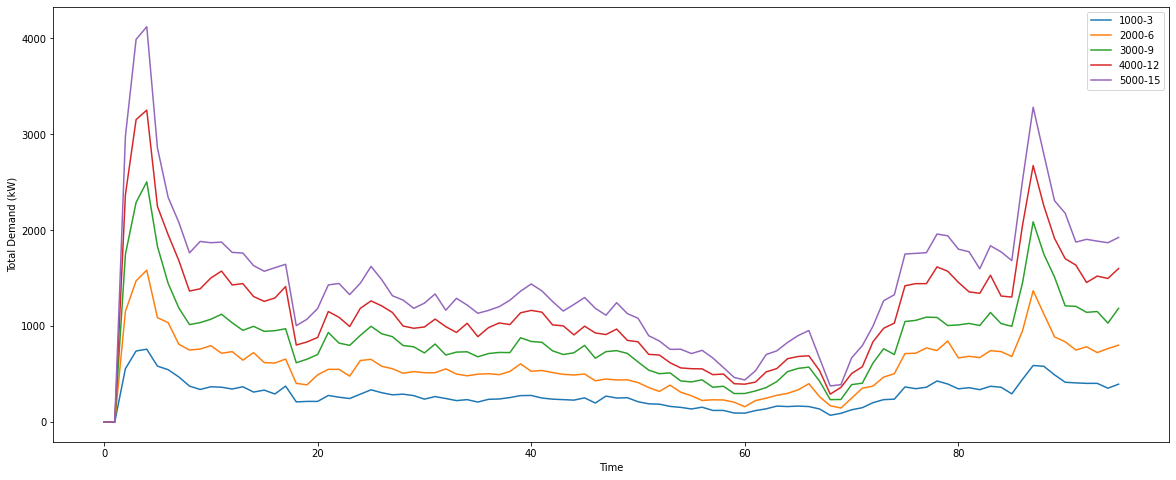

In [ ]:
_, ax = plt.subplots(figsize=(20,8))
for i in range(len(total_demand_profile_all[1])):
  ax.plot(list(range(T)),np.mean(total_demand_profile_all,axis=0)[i],label='{}-{}'.format(fleet_sizes[i],capacities[i]))
plt.xlabel('Time')
plt.ylabel('Total Demand (kW)')
plt.legend()

Total Utility: 5517616.558749013
Total Time Spent in Queue: 5194.6
Maximum Demand: 598.08
Total Money Spent: 37181.480981958375
Total Time Spent Repositioning: 17950.2
Plugs Used: 74.8


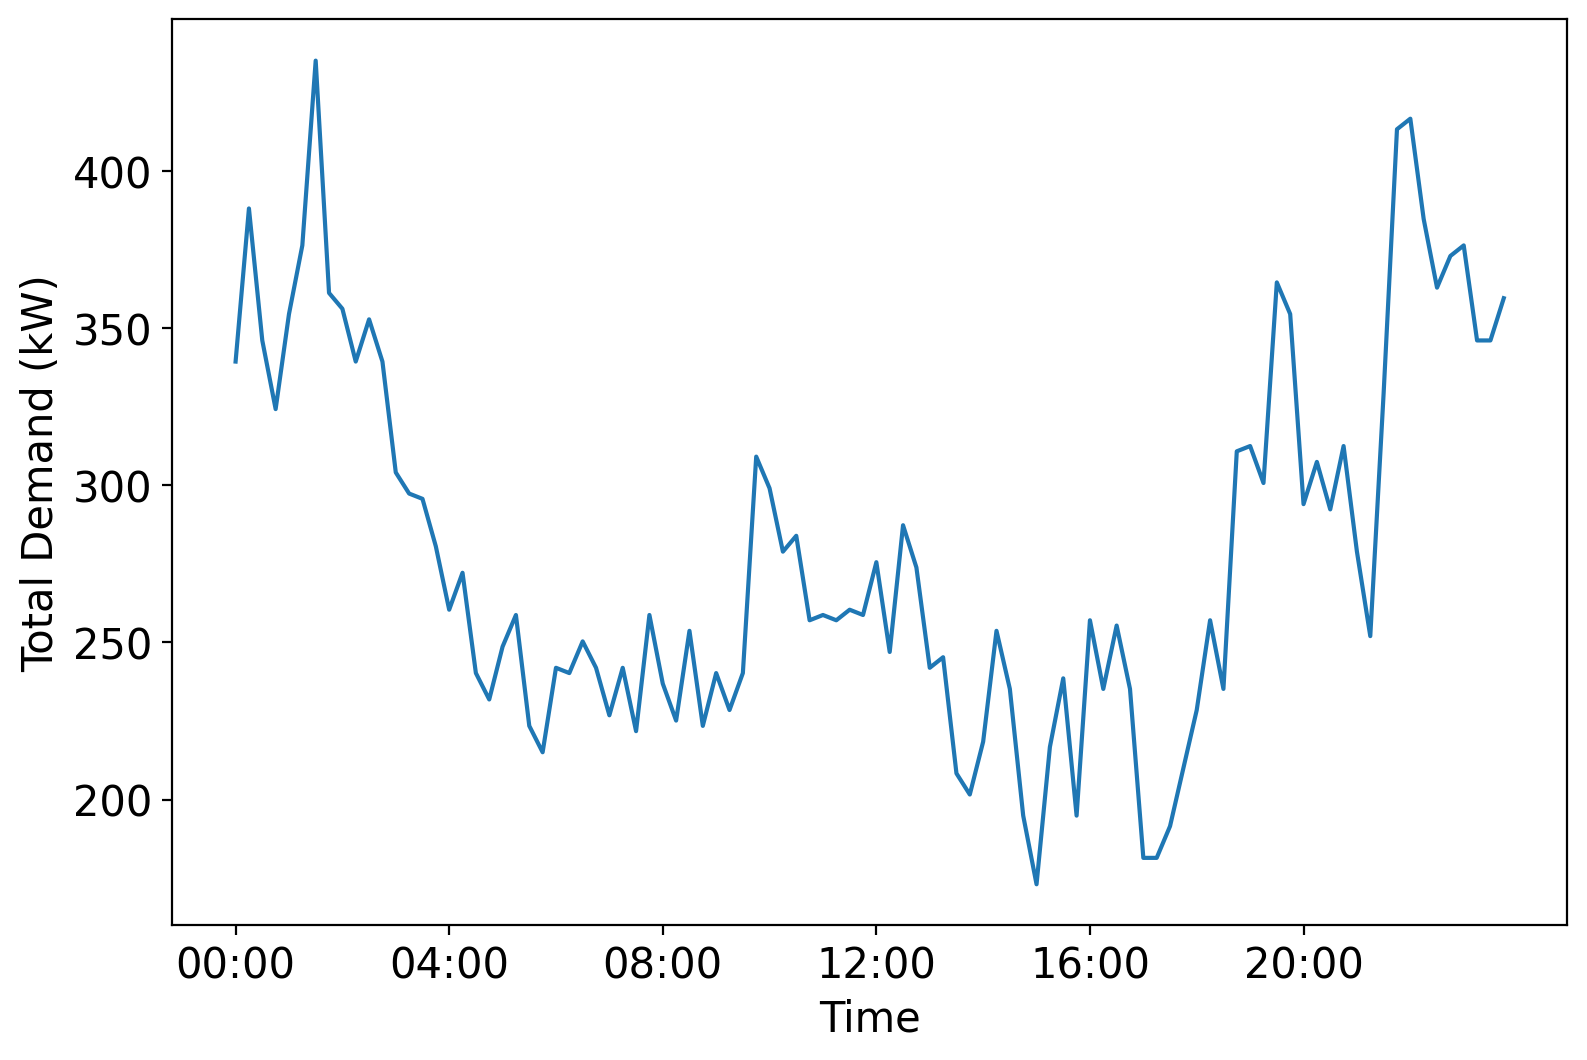

In [ ]:
# DEMAND1
exp_demand1 = Experiment(Simulation(1000, ("demand1", 0),3,wait_cost=0,know_prob=0))
exp_demand1.run()
plot_total_demand_profile_all(exp_demand1.total_demand_profile_all)

Total Utility: 5524353.0612735655
Total Time Spent in Queue: 8326.4
Maximum Demand: 712.32
Total Money Spent: 196074.00809239654
Total Time Spent Repositioning: 15769.3
Plugs Used: 71.2


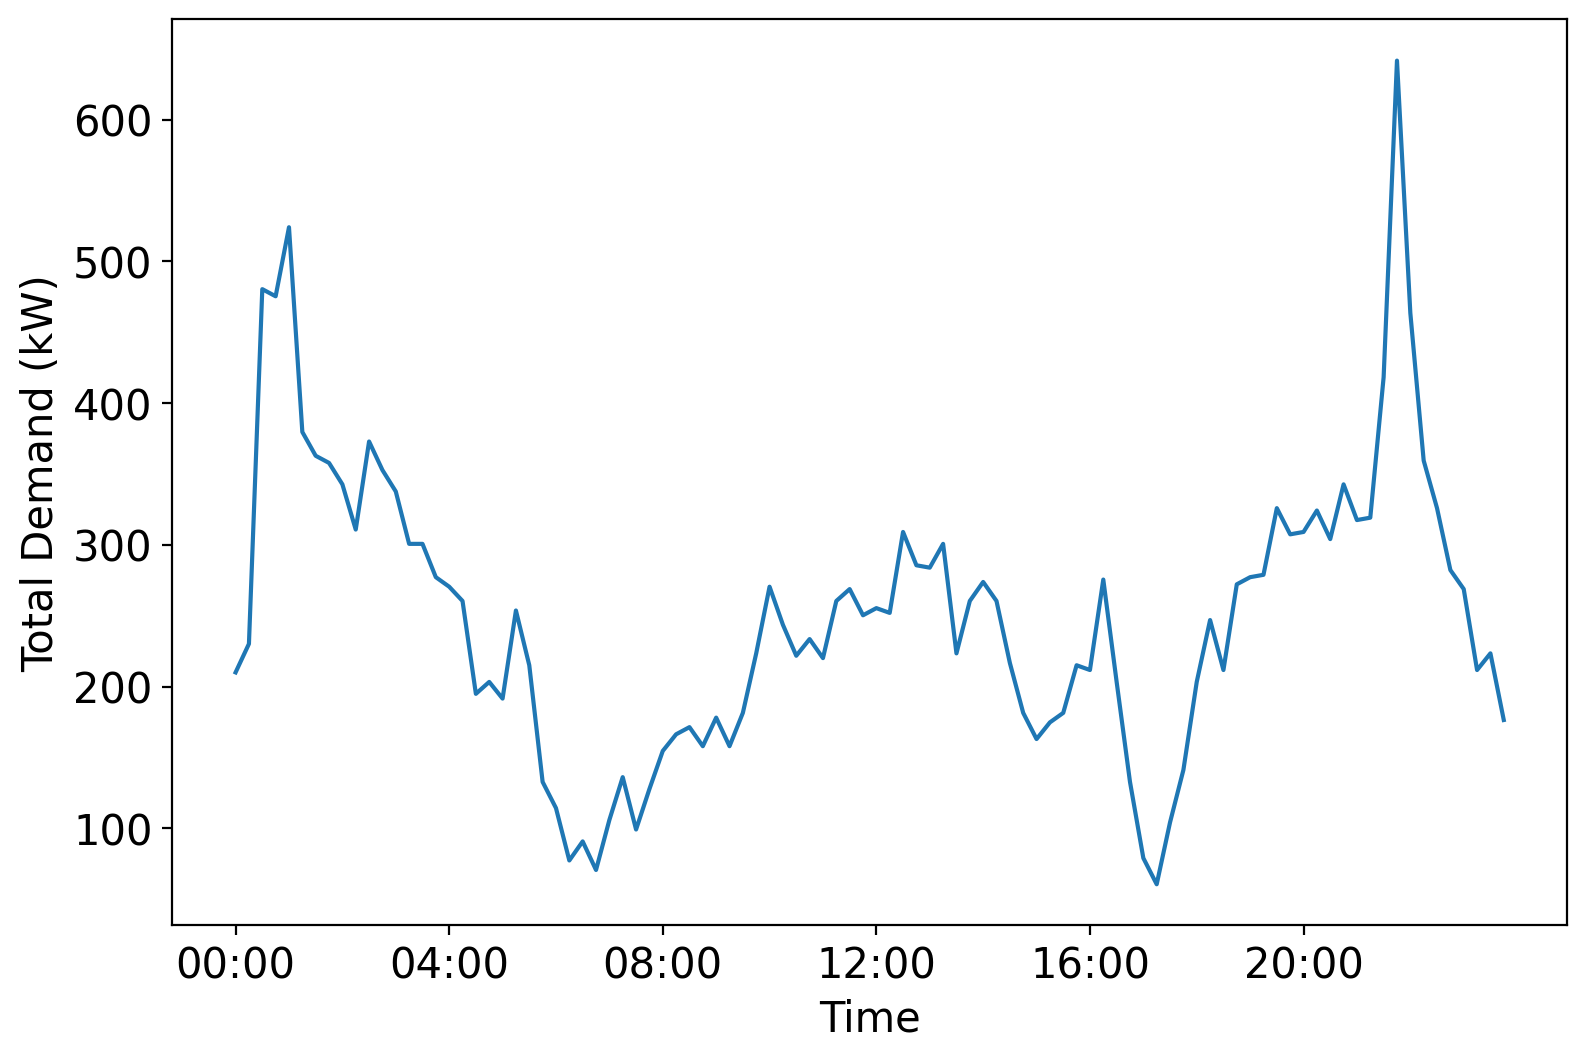

In [ ]:
# DEMAND2
exp_demand2 = Experiment(Simulation(1000, ("demand2", 0),3,wait_cost=0,know_prob=0))
exp_demand2.run()
plot_total_demand_profile_all(exp_demand2.total_demand_profile_all)

In [ ]:
# MISC - DO NOT RUN

In [ ]:
total_demand_profile = np.zeros(T)

for station in sim.stations:

  fig, ax1 = plt.subplots()

  color = 'tab:red'
  ax1.set_xlabel('time step')
  ax1.set_ylabel('Charging demand [kW]', color=color)
  ax1.set_ylim(0, CHARGE_RATE * 3)
  ax1.plot(np.arange(T), station.demand_profile, color=color)
  ax1.tick_params(axis='y', labelcolor=color)

  ax2 = ax1.twinx()

  color = 'tab:blue'
  ax2.set_ylabel('Queue length [# vehicles]', color=color)
  ax2.set_ylim(0, 75)
  ax2.plot(np.arange(T), station.queue_profile, color=color)
  ax2.tick_params(axis='y', labelcolor=color)

  fig.tight_layout() 
  ax1.set_title("Station #{}".format(station.location))
  plt.show()

  total_demand_profile += station.demand_profile

plt.figure()
plt.xlabel('time step')
plt.ylabel('Total charging demand [kW]')
plt.plot(np.arange(T), total_demand_profile)
plt.show()
print("Max power demand {}kW at t={}".format(max(total_demand_profile), np.argmax(total_demand_profile)))

Total trip utility = 1009550.7901853257
Total time spent in queue = 375
Total money spent in charging = 9685.730512058833


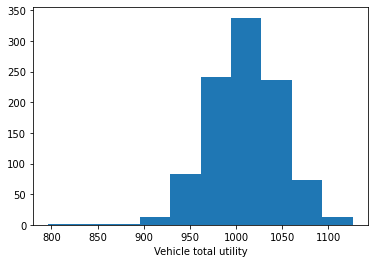

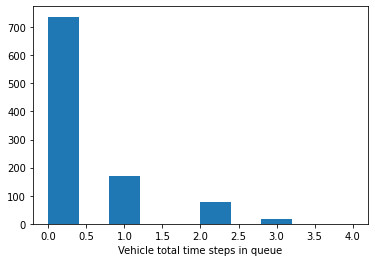

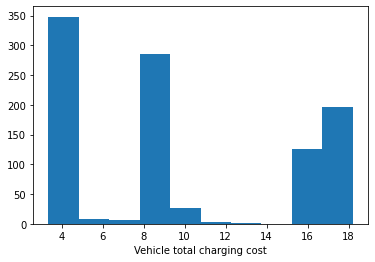

In [ ]:
vehicles_total_trip_utility = []
vehicles_time_spent_in_queue = []
vehicles_money_spent = []
for vehicle in sim.vehicles:
  vehicles_total_trip_utility.append(vehicle.total_trip_utility)
  vehicles_time_spent_in_queue.append(vehicle.time_spent_in_queue)
  vehicles_money_spent.append(vehicle.money_spent)

print("Total trip utility = {}".format(sum(vehicles_total_trip_utility)))
print("Total time spent in queue = {}".format(sum(vehicles_time_spent_in_queue)))
print("Total money spent in charging = {}".format(sum(vehicles_money_spent)))

plt.figure()
plt.hist(vehicles_total_trip_utility)
plt.xlabel("Vehicle total utility")
plt.show()

plt.figure()
plt.hist(vehicles_time_spent_in_queue)
plt.xlabel("Vehicle total time steps in queue")
plt.show()

plt.figure()
plt.hist(vehicles_money_spent)
plt.xlabel("Vehicle total charging cost")
plt.show()